# Preparation

In [ ]:
%%capture
!pip install arff2pandas
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from glob import glob
import time
import copy
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from multiprocess import cpu_count

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchvision import datasets, transforms, models

from arff2pandas import a2p
from collections import defaultdict

from transformers import get_linear_schedule_with_warmup, AdamW

NOTEBOOK=True
if NOTEBOOK:
  from tqdm.notebook import tqdm
else:
  from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 10, 4

In [ ]:
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


## About Dataset
This dataset contains a set of N = 5000 univariate time series with 140 timesteps (T = 140).  Each sequence corresponds to one heartbeat. Five classes are annotated, corresponding to the following labels: Normal (N), R-on-T Premature Ventricular Contraction (R-on-T PVC), Premature Ventricular Contraction (PVC), Supra-ventricular Premature or Ectopic Beat (SP or EB) and Unclassified Beat (UB). 

[Dataset Decription Link 1](https://link.springer.com/article/10.1007%2Fs10618-014-0388-4)

[Dataset Description Link 2](https://ieeexplore.ieee.org/document/8679157)

In [ ]:
base_path = "/content/drive/MyDrive/applied_ai_enes_safak/datasets/ECG5000/"
with open(base_path + "ECG5000_TRAIN.arff") as f:
  train = a2p.load(f)

with open(base_path + "ECG5000_TEST.arff") as f:
  test = a2p.load(f)

In [ ]:
train.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.40638

In [ ]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
class_names = ['Normal','R on T','PVC','SP','UB']

In [ ]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

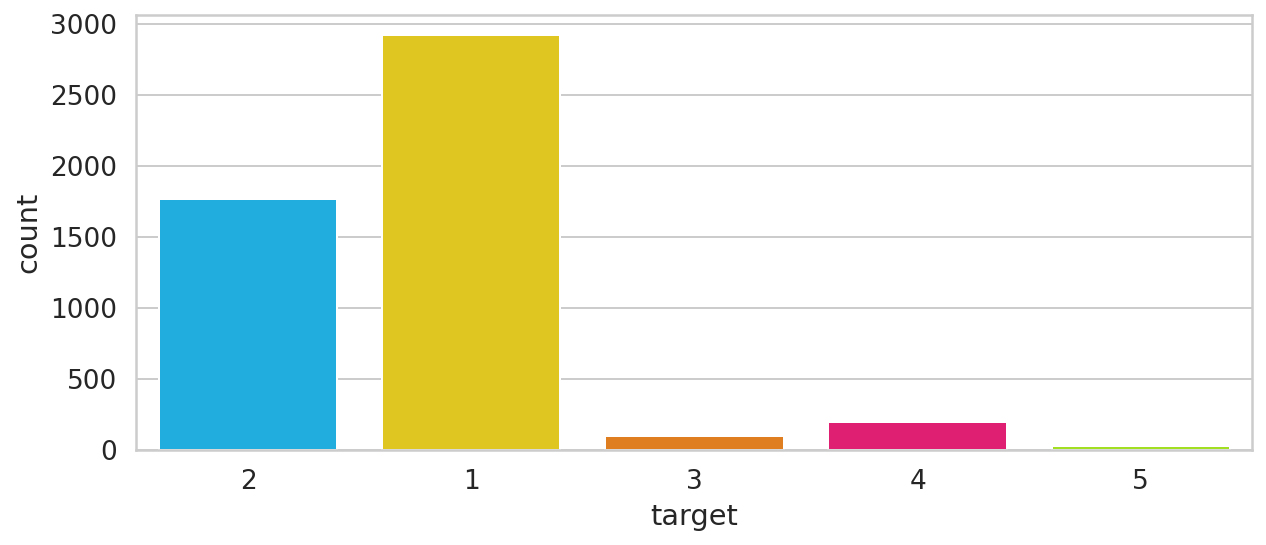

In [ ]:
ax = sns.countplot(df.target)

* Normal: 1
* R-on-T Premature Ventricular Contradiction (R-on-T PVC): 2
* Prematyre Ventricular Contraction (PVC): 3
* Supra-venctricular Premature or Ectopic Beat (SP or EB): 4
* Unclassified Beat (UB): 5

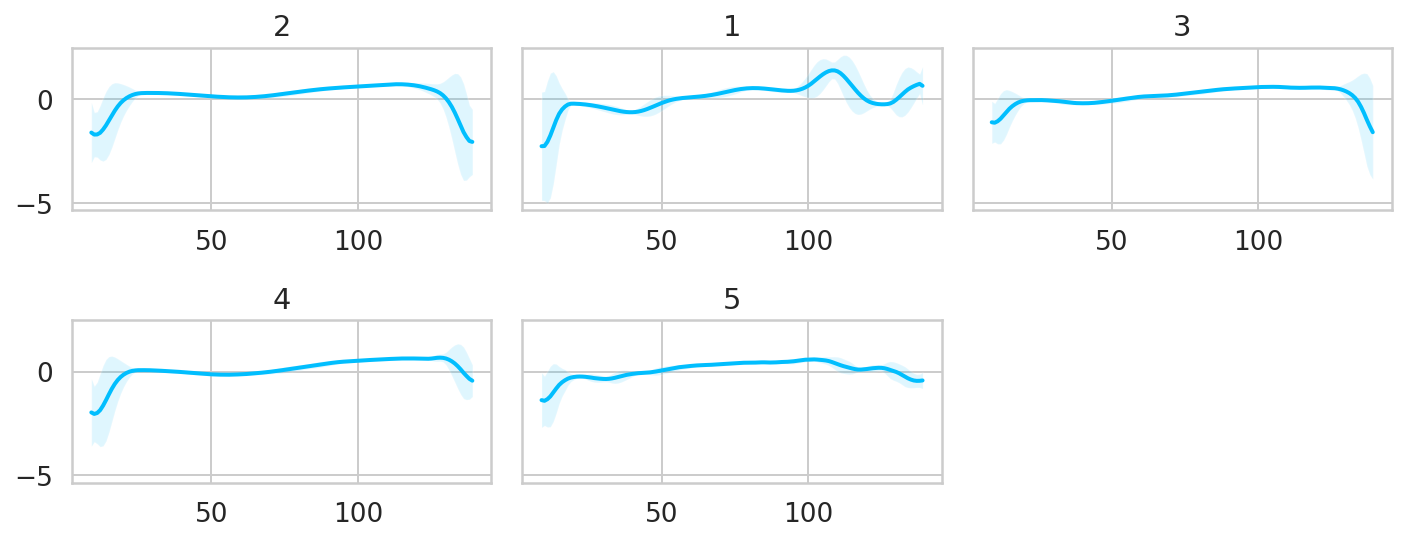

In [ ]:
def plot_classes(data, class_name, ax, cls, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=0.125,
  )
  ax.set_title(str(cls))

classes = df["target"].unique()
fig, axs = plt.subplots(
    nrows=len(classes)// 3 + 1,
    ncols = 3,
    sharey = True,
    figsize = (10,4)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df["target"] == cls].drop(labels="target",axis=1).mean(axis=0).to_numpy()
  plot_classes(data, class_names[i], ax, cls)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

# Preprocessing

In [ ]:
CLASS_NORMAL = 1
normal_df = df[df["target"] == str(CLASS_NORMAL)].drop(labels="target", axis=1)
print(normal_df.shape)

(2919, 140)


In [ ]:
anomaly_df = df[df["target"] != str(CLASS_NORMAL)].drop(labels="target", axis=1)
print(anomaly_df.shape)

(2081, 140)


In [ ]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size = 0.33, random_state=RANDOM_SEED)
print(train_df.shape, val_df.shape, test_df.shape)

(2481, 140) (293, 140) (145, 140)


In [ ]:
BATCH_SIZE = 16
SEQ_LEN = 140
N_FEATURES = 1

def train_dataset(df,batch_size):
  torch_df = torch.tensor(df.to_numpy())
  train_data = TensorDataset(torch_df)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

def test_dataset(df, batch_size):
  torch_df = torch.tensor(df.to_numpy())
  val_data = TensorDataset(torch_df)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
  return val_dataloader

train_dataloader = train_dataset(train_df, BATCH_SIZE)
val_dataloader = test_dataset(val_df, BATCH_SIZE)
test_dataloader = test_dataset(test_df, BATCH_SIZE)

anomaly_dataloader = test_dataset(anomaly_df, 1)

print(next(iter(train_dataloader))[0].shape)
print(next(iter(val_dataloader))[0].shape)
print(next(iter(test_dataloader))[0].shape)
print(next(iter(anomaly_dataloader))[0].shape)

torch.Size([16, 140])
torch.Size([16, 140])
torch.Size([16, 140])
torch.Size([1, 140])


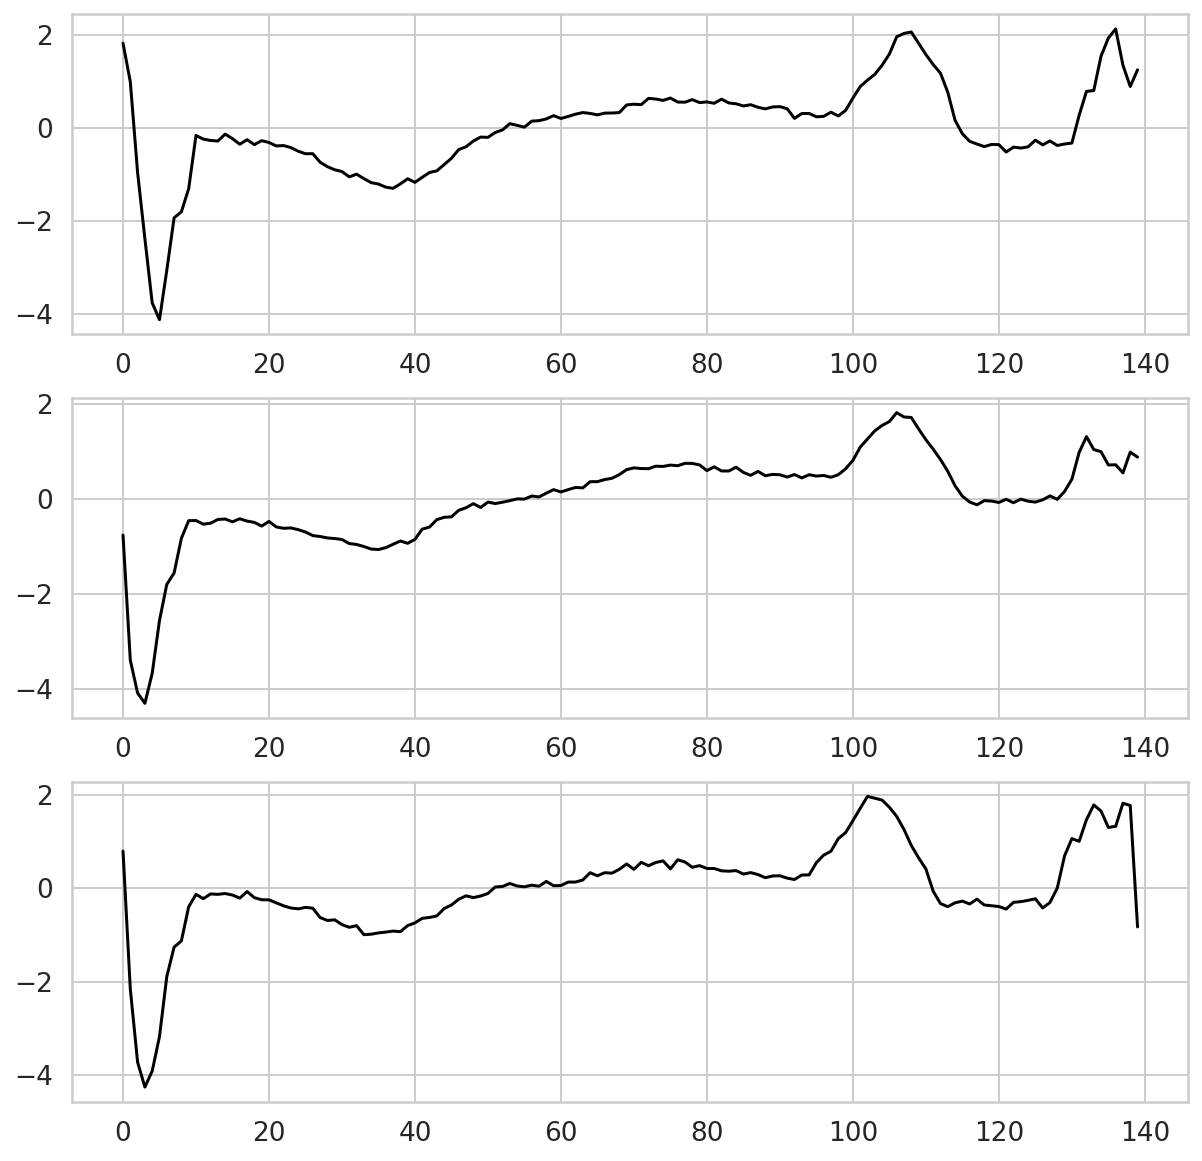

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
samples = torch.randint(0, 16, (3,))
axs[0].plot(next(iter(train_dataloader))[0][samples[0]].numpy(), color="black")
axs[1].plot(next(iter(train_dataloader))[0][samples[1]].numpy(), color="black")
axs[2].plot(next(iter(train_dataloader))[0][samples[2]].numpy(), color="black");

# Model

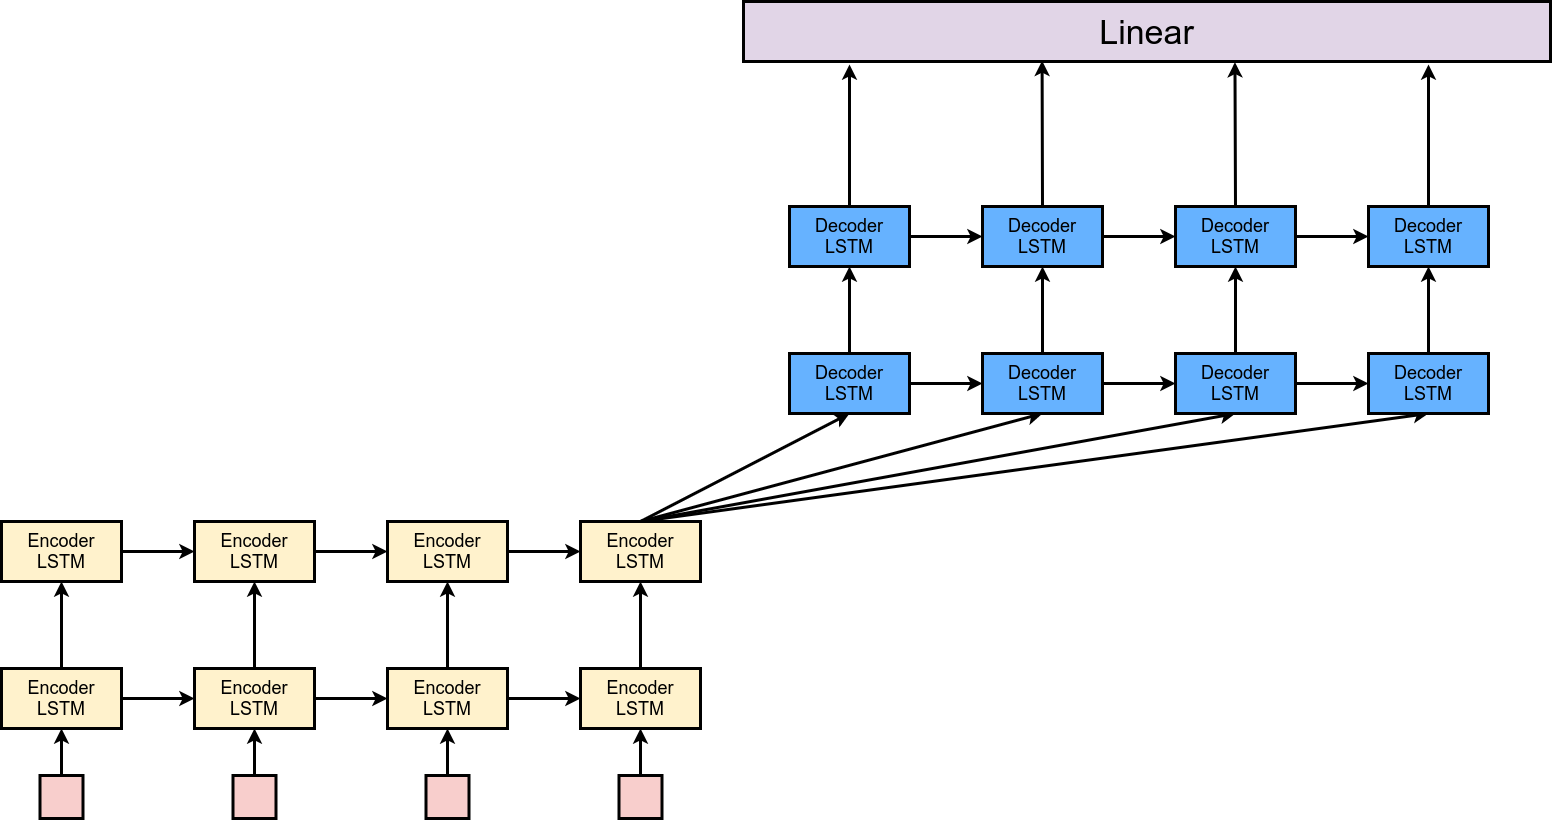

In [ ]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, hidden_dim = 64):
    super(Encoder, self).__init__()

    self.seq_len = seq_len
    self.n_features = n_features
    self.hidden_dim_1 = hidden_dim
    self.hidden_dim_2 = 2*hidden_dim

    self.lstm1 = nn.LSTM(
        input_size = n_features,
        hidden_size = self.hidden_dim_2,
        num_layers = 1,
        batch_first = True
    )

    self.lstm2 = nn.LSTM(
        input_size = self.hidden_dim_2,
        hidden_size = self.hidden_dim_1,
        num_layers = 1,
        batch_first = True
    )

  def forward(self,x):
    # x: [B, seq_len] == [B, 140]
    x = torch.unsqueeze(x, dim = 2).float() 
    # [B, seq_len] -> [B, seq_len, n_features] == [B, seq_len, 1]

    out, (hidden, cell) = self.lstm1(x) 
    # out:    [B, seq_len, n_features] -> [B, seq_len, hidden_dim_1 * 2]
    # hidden: [B, seq_len, n_features] -> [1, B, hidden_dim_1 * 2]
    # cell:   [B, seq_len, n_features] -> [1, B, hidden_dim_1 * 2]

    out, (hidden, cell) = self.lstm2(out)
    # out:    [B, seq_len, hidden_dim_1 * 2] -> [B, seq_len, hidden_dim_1]
    # hidden: [B, seq_len, hidden_dim_1 * 2] -> [1, B, hidden_dim_1]
    # cell:   [B, seq_len, hidden_dim_1 * 2] -> [1, B, hidden_dim_1]

    out = torch.squeeze(hidden, dim=0)
    # [1, B, hidden_dim_1] -> [B, hidden_dim_1]
    return out

In [ ]:
class Decoder(nn.Module):
  def __init__(self, seq_len, n_features=1, encoder_hidden_dim=64):
    super(Decoder, self).__init__()
    self.seq_len = seq_len
    self.n_features = n_features
    
    self.encoder_hidden_dim = encoder_hidden_dim
    self.hidden_dim = encoder_hidden_dim * 2

    self.lstm1 = nn.LSTM(
        input_size = encoder_hidden_dim,
        hidden_size = encoder_hidden_dim,
        num_layers = 1,
        batch_first = True
    )

    self.lstm2 = nn.LSTM(
        input_size = encoder_hidden_dim,
        hidden_size = self.hidden_dim,
        num_layers = 1,
        batch_first = True
    )

    self.fcn = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    # x: [B, encoder_hidden_dim]
    batch_size = x.size(0)
    x = x.repeat(self.seq_len, self.n_features)
    # [B, encoder_hidden_dim] -> [B*self.seq_len, encoder_hidden_dim]
    x = x.reshape(batch_size, -1, self.encoder_hidden_dim)
    # [B*self.seq_len, encoder_hidden_dim] -> [B, seq_len, encoder_hidden_dim]
    
    x, (hidden, cell) = self.lstm1(x)
    # x:      [B, seq_len, encoder_hidden_dim] -> [B, seq_len, encoder_hidden_dim]
    # hidden: [B, seq_len, encoder_hidden_dim] -> [1, B, encoder_hidden_dim]
    # cell:   [B, seq_len, encoder_hidden_dim] -> [1, B, encoder_hidden_dim]

    x, (hidden, cell) = self.lstm2(x)
    # x:      [B, seq_len, encoder_hidden_dim] -> [B, seq_len, hidden_dim]
    # hidden: [B, seq_len, encoder_hidden_dim] -> [1, B, hidden_dim]
    # cell:   [B, seq_len, encoder_hidden_dim] -> [1, B, hidden_dim]

    x = self.fcn(x)
    # x:      [B, seq_len, hidden_dim] -> [B, seq_len, 1]
    x = torch.squeeze(x, dim=-1)
    return x

In [ ]:
class LSTMAE(nn.Module):
  def __init__(self, seq_len, n_features, device, hidden_dim = 64):
    super(LSTMAE, self).__init__()

    self.seq_len = seq_len
    self.n_features = n_features
    self.embedding_dim = hidden_dim

    self.encoder = Encoder(seq_len, n_features, hidden_dim).to(device)
    self.decoder = Decoder(seq_len, n_features, hidden_dim).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
model = LSTMAE(SEQ_LEN, N_FEATURES, device, hidden_dim = 128).to(device)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of trainable parameters: {params}")

Number of trainable parameters: 990465


In [ ]:
print(model)

LSTMAE(
  (encoder): Encoder(
    (lstm1): LSTM(1, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (fcn): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
model(next(iter(anomaly_test_dataloader))[0].to(device)).shape

torch.Size([1, 140])

# Training

In [ ]:
def train(model, optimizer, criterion,  train_dataloader,  val_dataloader,  device, 
          EPOCHS,  EVALUATE_EVERY,  scheduler=None,  gradient_clipping=False,  gradient_clipping_rate = 1.0, evaluate_epoch=False):
  model = model.to(device)
  total = len(train_dataloader) * EPOCHS
  log = defaultdict(list)
  log["train_loss"] = []
  log["eval_loss"] = []
  loss_a = []
  with tqdm(total = total) as tt:
    for epoch in range(EPOCHS):
      total_loss, batch_loss, batch_counts = 0, 0, 0
      for step, batch in enumerate(train_dataloader):
        model.train()
        batch_counts +=1
        b_inputs, = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()

        out = model.forward(b_inputs)
        loss = criterion(out, b_inputs)
        batch_loss += loss.item()
        total_loss += loss.item()
        loss_a.append(loss.detach().cpu().numpy())

        loss.backward()

        if gradient_clipping:
          torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_rate)
        optimizer.step()
        if scheduler != None:
          scheduler.step()

        if (evaluate_epoch == False) and step % EVALUATE_EVERY == 0:
          val_loss = evaluate(model, criterion, val_dataloader, device)
          print(f"train loss: {batch_loss / batch_counts}, val loss: {val_loss}")
          log["train_loss"].append(batch_loss / batch_counts)
          log["eval_loss"].append(val_loss)

        tt.update()

      if evaluate_epoch:
        val_loss = evaluate(model, criterion, val_dataloader, device)
        #print(f"({epoch+1}/{EPOCHS}) -> train loss: {total_loss / len(train_dataloader)}, val loss: {val_loss}")
        print(f"({epoch+1}/{EPOCHS}) -> train loss: {np.mean(loss_a)}, val loss: {val_loss}")
        log["train_loss"].append(total_loss / len(train_dataloader))
        log["eval_loss"].append(val_loss)

        if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
          print(f"Best model is stored with eval loss {val_loss}.")
          best_model = model
    print("Done.")
    tt.close()
  return model, best_model, log

In [ ]:
def evaluate(model, criterion, val_dataloader, device):
  total = len(val_dataloader)
  print("Evaluating...")
  loss_a = []
  with tqdm(total = total) as ee:
    val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
    for step, batch in enumerate(val_dataloader):
      model.eval()
      val_batch_loss += 1
      b_inputs, = tuple(t.to(device) for t in batch)
      
      with torch.no_grad():
        out = model.forward(b_inputs)

      loss = criterion(out, b_inputs)
      loss_a.append(loss.detach().cpu().numpy())
      #val_batch_loss += loss.item()
      #val_loss += loss.item()
      ee.update()
    ee.close()
  #return val_loss/total
  return np.mean(loss_a)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.L1Loss(reduction="sum")
EPOCHS = 125
EVALUATE_EVERY = 100

optimizer = AdamW(
    model.parameters(),
    lr=0.0005,
    eps=1e-9,
    betas = (0.9, 0.98)
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * 5
)

In [ ]:
model, best_model, log = train(
    model = model,
    optimizer = optimizer, 
    criterion = criterion, 
    train_dataloader = train_dataloader, 
    val_dataloader = val_dataloader, 
    device = device, 
    EPOCHS = EPOCHS, 
    EVALUATE_EVERY = EVALUATE_EVERY, 
    evaluate_epoch=True)

Evaluating...



(1/125) -> train loss: 1349.85400390625, val loss: 1108.4178466796875
Best model is stored with eval loss 1108.4178466796875.
Evaluating...



(2/125) -> train loss: 1244.2197265625, val loss: 1129.37744140625
Evaluating...



(3/125) -> train loss: 1139.5391845703125, val loss: 910.083251953125
Best model is stored with eval loss 910.083251953125.
Evaluating...



(4/125) -> train loss: 1077.146240234375, val loss: 840.816650390625
Best model is stored with eval loss 840.816650390625.
Evaluating...



(5/125) -> train loss: 1037.97802734375, val loss: 845.8494262695312
Evaluating...



(6/125) -> train loss: 1011.6432495117188, val loss: 840.0457153320312
Best model is stored with eval loss 840.0457153320312.
Evaluating...



(7/125) -> train loss: 991.8965454101562, val loss: 834.2338256835938
Best model is stored with eval loss 834.2338256835938.
Evaluating...



(8/125) -> train loss: 977.0109252929688, val loss: 842.0281982421875
Evaluating...



(9/125) -> train loss: 965.4193115234375, val loss: 833.2998657226562
Best model is stored with eval loss 833.2998657226562.
Evaluating...



(10/125) -> train loss: 955.0309448242188, val loss: 810.669921875
Best model is stored with eval loss 810.669921875.
Evaluating...



(11/125) -> train loss: 941.6531372070312, val loss: 852.60009765625
Evaluating...



(12/125) -> train loss: 924.8546752929688, val loss: 719.6405639648438
Best model is stored with eval loss 719.6405639648438.
Evaluating...



(13/125) -> train loss: 909.1383056640625, val loss: 727.9659423828125
Evaluating...



(14/125) -> train loss: 892.8711547851562, val loss: 624.8455200195312
Best model is stored with eval loss 624.8455200195312.
Evaluating...



(15/125) -> train loss: 877.626220703125, val loss: 638.175537109375
Evaluating...



(16/125) -> train loss: 864.78076171875, val loss: 678.2904052734375
Evaluating...



(17/125) -> train loss: 852.2950439453125, val loss: 703.622802734375
Evaluating...



(18/125) -> train loss: 841.1127319335938, val loss: 598.5828857421875
Best model is stored with eval loss 598.5828857421875.
Evaluating...



(19/125) -> train loss: 830.9151611328125, val loss: 667.0499877929688
Evaluating...



(20/125) -> train loss: 822.958984375, val loss: 671.3357543945312
Evaluating...



(21/125) -> train loss: 814.6688232421875, val loss: 609.8659057617188
Evaluating...



(22/125) -> train loss: 806.9249267578125, val loss: 616.6083984375
Evaluating...



(23/125) -> train loss: 800.237060546875, val loss: 596.04833984375
Best model is stored with eval loss 596.04833984375.
Evaluating...



(24/125) -> train loss: 793.7182006835938, val loss: 617.22021484375
Evaluating...



(25/125) -> train loss: 787.6675415039062, val loss: 621.6257934570312
Evaluating...



(26/125) -> train loss: 782.0584716796875, val loss: 618.3331909179688
Evaluating...



(27/125) -> train loss: 776.8411254882812, val loss: 621.3338012695312
Evaluating...



(28/125) -> train loss: 772.0020141601562, val loss: 594.333740234375
Best model is stored with eval loss 594.333740234375.
Evaluating...



(29/125) -> train loss: 767.767822265625, val loss: 612.6195678710938
Evaluating...



(30/125) -> train loss: 763.4905395507812, val loss: 664.2752075195312
Evaluating...



(31/125) -> train loss: 759.6056518554688, val loss: 600.1080322265625
Evaluating...



(32/125) -> train loss: 755.9368286132812, val loss: 604.24658203125
Evaluating...



(33/125) -> train loss: 752.367919921875, val loss: 635.0731811523438
Evaluating...



(34/125) -> train loss: 749.1031494140625, val loss: 598.75341796875
Evaluating...



(35/125) -> train loss: 746.00048828125, val loss: 619.723388671875
Evaluating...



(36/125) -> train loss: 743.0237426757812, val loss: 599.5342407226562
Evaluating...



(37/125) -> train loss: 740.2534790039062, val loss: 633.6129150390625
Evaluating...



(38/125) -> train loss: 737.580322265625, val loss: 621.3521118164062
Evaluating...



(39/125) -> train loss: 735.125244140625, val loss: 594.460693359375
Evaluating...



(40/125) -> train loss: 732.6065673828125, val loss: 612.7330322265625
Evaluating...



(41/125) -> train loss: 730.3038330078125, val loss: 638.2821655273438
Evaluating...



(42/125) -> train loss: 728.0963745117188, val loss: 612.6700439453125
Evaluating...



(43/125) -> train loss: 726.1364135742188, val loss: 601.0773315429688
Evaluating...



(44/125) -> train loss: 724.1593627929688, val loss: 589.4087524414062
Best model is stored with eval loss 589.4087524414062.
Evaluating...



(45/125) -> train loss: 722.1689453125, val loss: 603.6181030273438
Evaluating...



(46/125) -> train loss: 720.3777465820312, val loss: 605.4645385742188
Evaluating...



(47/125) -> train loss: 718.6038208007812, val loss: 639.40869140625
Evaluating...



(48/125) -> train loss: 716.8826293945312, val loss: 587.1051025390625
Best model is stored with eval loss 587.1051025390625.
Evaluating...



(49/125) -> train loss: 715.25341796875, val loss: 601.5586547851562
Evaluating...



(50/125) -> train loss: 713.6380615234375, val loss: 610.4583129882812
Evaluating...



(51/125) -> train loss: 712.1411743164062, val loss: 609.4744262695312
Evaluating...



(52/125) -> train loss: 710.6670532226562, val loss: 616.442138671875
Evaluating...



(53/125) -> train loss: 709.2327270507812, val loss: 598.3375244140625
Evaluating...



(54/125) -> train loss: 707.9244995117188, val loss: 595.4711303710938
Evaluating...



(55/125) -> train loss: 706.5840454101562, val loss: 632.106689453125
Evaluating...



(56/125) -> train loss: 705.3643798828125, val loss: 593.7384643554688
Evaluating...



(57/125) -> train loss: 704.1732177734375, val loss: 609.7925415039062
Evaluating...



(58/125) -> train loss: 702.9730834960938, val loss: 590.7305297851562
Evaluating...



(59/125) -> train loss: 701.8084716796875, val loss: 603.9566650390625
Evaluating...



(60/125) -> train loss: 700.6387329101562, val loss: 587.4480590820312
Evaluating...



(61/125) -> train loss: 699.5366821289062, val loss: 601.3074340820312
Evaluating...



(62/125) -> train loss: 698.4755249023438, val loss: 590.9154052734375
Evaluating...



(63/125) -> train loss: 697.5200805664062, val loss: 628.8858642578125
Evaluating...



(64/125) -> train loss: 696.4574584960938, val loss: 596.7792358398438
Evaluating...



(65/125) -> train loss: 695.4843139648438, val loss: 598.0682983398438
Evaluating...



(66/125) -> train loss: 694.49462890625, val loss: 585.1885375976562
Best model is stored with eval loss 585.1885375976562.
Evaluating...



(67/125) -> train loss: 693.5270385742188, val loss: 585.1593627929688
Best model is stored with eval loss 585.1593627929688.
Evaluating...



(68/125) -> train loss: 692.6158447265625, val loss: 587.7080688476562
Evaluating...



(69/125) -> train loss: 691.7224731445312, val loss: 590.078369140625
Evaluating...



(70/125) -> train loss: 690.8365478515625, val loss: 587.1513061523438
Evaluating...



(71/125) -> train loss: 689.9945678710938, val loss: 587.6896362304688
Evaluating...



(72/125) -> train loss: 689.2080688476562, val loss: 586.92724609375
Evaluating...



(73/125) -> train loss: 688.3803100585938, val loss: 595.9381713867188
Evaluating...



(74/125) -> train loss: 687.6032104492188, val loss: 597.4852294921875
Evaluating...



(75/125) -> train loss: 686.8916625976562, val loss: 588.4002075195312
Evaluating...



(76/125) -> train loss: 686.1153564453125, val loss: 586.6355590820312
Evaluating...



(77/125) -> train loss: 685.3862915039062, val loss: 590.5388793945312
Evaluating...



(78/125) -> train loss: 684.6897583007812, val loss: 587.78857421875
Evaluating...



(79/125) -> train loss: 683.9835815429688, val loss: 586.6990966796875
Evaluating...



(80/125) -> train loss: 683.2921752929688, val loss: 585.5929565429688
Evaluating...



(81/125) -> train loss: 682.601318359375, val loss: 586.663330078125
Evaluating...



(82/125) -> train loss: 681.9413452148438, val loss: 582.74951171875
Best model is stored with eval loss 582.74951171875.
Evaluating...



(83/125) -> train loss: 681.2924194335938, val loss: 591.3333740234375
Evaluating...



(84/125) -> train loss: 680.6806030273438, val loss: 582.4837646484375
Best model is stored with eval loss 582.4837646484375.
Evaluating...



(85/125) -> train loss: 680.0536499023438, val loss: 583.9041137695312
Evaluating...



(86/125) -> train loss: 679.440673828125, val loss: 582.093017578125
Best model is stored with eval loss 582.093017578125.
Evaluating...



(87/125) -> train loss: 678.831787109375, val loss: 584.5164794921875
Evaluating...



(88/125) -> train loss: 678.2484130859375, val loss: 584.83056640625
Evaluating...



(89/125) -> train loss: 677.7067260742188, val loss: 585.3259887695312
Evaluating...



(90/125) -> train loss: 677.1646728515625, val loss: 581.3432006835938
Best model is stored with eval loss 581.3432006835938.
Evaluating...



(91/125) -> train loss: 676.6353759765625, val loss: 600.74609375
Evaluating...



(92/125) -> train loss: 676.0823974609375, val loss: 589.3246459960938
Evaluating...



(93/125) -> train loss: 675.5792236328125, val loss: 583.2169799804688
Evaluating...



(94/125) -> train loss: 675.0474853515625, val loss: 599.4479370117188
Evaluating...



(95/125) -> train loss: 674.5331420898438, val loss: 589.7057495117188
Evaluating...



(96/125) -> train loss: 674.0280151367188, val loss: 585.32763671875
Evaluating...



(97/125) -> train loss: 673.5615844726562, val loss: 586.310546875
Evaluating...



(98/125) -> train loss: 673.0804443359375, val loss: 586.44677734375
Evaluating...



(99/125) -> train loss: 672.595458984375, val loss: 581.2764892578125
Best model is stored with eval loss 581.2764892578125.
Evaluating...



(100/125) -> train loss: 672.1522827148438, val loss: 585.7583618164062
Evaluating...



(101/125) -> train loss: 671.7089233398438, val loss: 588.1624145507812
Evaluating...



(102/125) -> train loss: 671.2761840820312, val loss: 584.7574462890625
Evaluating...



(103/125) -> train loss: 670.8372192382812, val loss: 581.651123046875
Evaluating...



(104/125) -> train loss: 670.4052124023438, val loss: 585.4196166992188
Evaluating...



(105/125) -> train loss: 669.9790649414062, val loss: 584.8914184570312
Evaluating...



(106/125) -> train loss: 669.5537719726562, val loss: 584.1397705078125
Evaluating...



(107/125) -> train loss: 669.138916015625, val loss: 581.7163696289062
Evaluating...



(108/125) -> train loss: 668.7389526367188, val loss: 579.9744262695312
Best model is stored with eval loss 579.9744262695312.
Evaluating...



(109/125) -> train loss: 668.331787109375, val loss: 589.4293823242188
Evaluating...



(110/125) -> train loss: 667.9398193359375, val loss: 582.5533447265625
Evaluating...



(111/125) -> train loss: 667.552001953125, val loss: 585.0263061523438
Evaluating...



(112/125) -> train loss: 667.1751098632812, val loss: 579.7401123046875
Best model is stored with eval loss 579.7401123046875.
Evaluating...



(113/125) -> train loss: 666.7957153320312, val loss: 580.6193237304688
Evaluating...



(114/125) -> train loss: 666.430419921875, val loss: 633.0054321289062
Evaluating...



(115/125) -> train loss: 666.0878295898438, val loss: 584.4140625
Evaluating...



(116/125) -> train loss: 665.7483520507812, val loss: 579.8076782226562
Evaluating...



(117/125) -> train loss: 665.4140014648438, val loss: 587.2760620117188
Evaluating...



(118/125) -> train loss: 665.0637817382812, val loss: 578.9570922851562
Best model is stored with eval loss 578.9570922851562.
Evaluating...



(119/125) -> train loss: 664.7469482421875, val loss: 596.9656982421875
Evaluating...



(120/125) -> train loss: 664.4234619140625, val loss: 586.3192749023438
Evaluating...



(121/125) -> train loss: 664.1099853515625, val loss: 591.1672973632812
Evaluating...



(122/125) -> train loss: 663.79541015625, val loss: 581.9456787109375
Evaluating...



(123/125) -> train loss: 663.4761962890625, val loss: 595.42041015625
Evaluating...



(124/125) -> train loss: 663.1650390625, val loss: 582.953369140625
Evaluating...



(125/125) -> train loss: 662.8569946289062, val loss: 580.1121215820312
Done.



In [ ]:
torch.save(best_model.state_dict(), "/content/drive/MyDrive/applied_ai_enes_safak/Time Series/anomaly_ckpts/best_model.pt")
torch.save(model.state_dict(), "/content/drive/MyDrive/applied_ai_enes_safak/Time Series/anomaly_ckpts/model.pt")

In [ ]:
model = LSTMAE(SEQ_LEN, N_FEATURES, device, hidden_dim = 128).to(device)
best_model = LSTMAE(SEQ_LEN, N_FEATURES, device, hidden_dim = 128).to(device)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/applied_ai_enes_safak/Time Series/anomaly_ckpts/best_model.pt"))
#model.load_state_dict(torch.load("/content/drive/MyDrive/applied_ai_enes_safak/Time Series/anomaly_ckpts/model.pt"))

<All keys matched successfully>

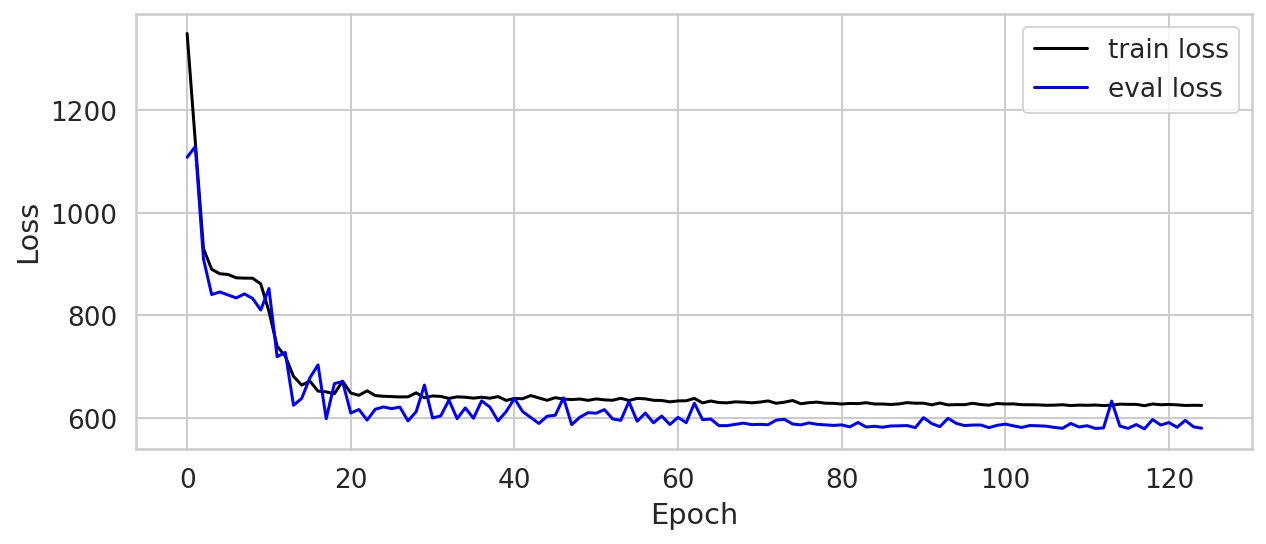

In [ ]:
plt.plot(log["train_loss"], label = "train loss", color = "black")
plt.plot(log["eval_loss"], label = "eval loss", color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation

In [ ]:
def thresholding(model, criterion, dataset, device):
  preds, losses = [], []
  total = len(dataset)
  dataset = train_dataset(dataset, 1)
  with tqdm(total = total) as ee:
    with torch.no_grad():
      for step, batch in enumerate(dataset):
        model.eval()
        b_inputs, = tuple(t.to(device) for t in batch)
        out = model.forward(b_inputs)

        loss = criterion(out, b_inputs)

        preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
        losses.append(loss.detach().cpu().numpy())
        ee.update()
    ee.close()

  return preds, losses

In [ ]:
reconstructions, losses = thresholding(best_model, criterion, train_df, device)

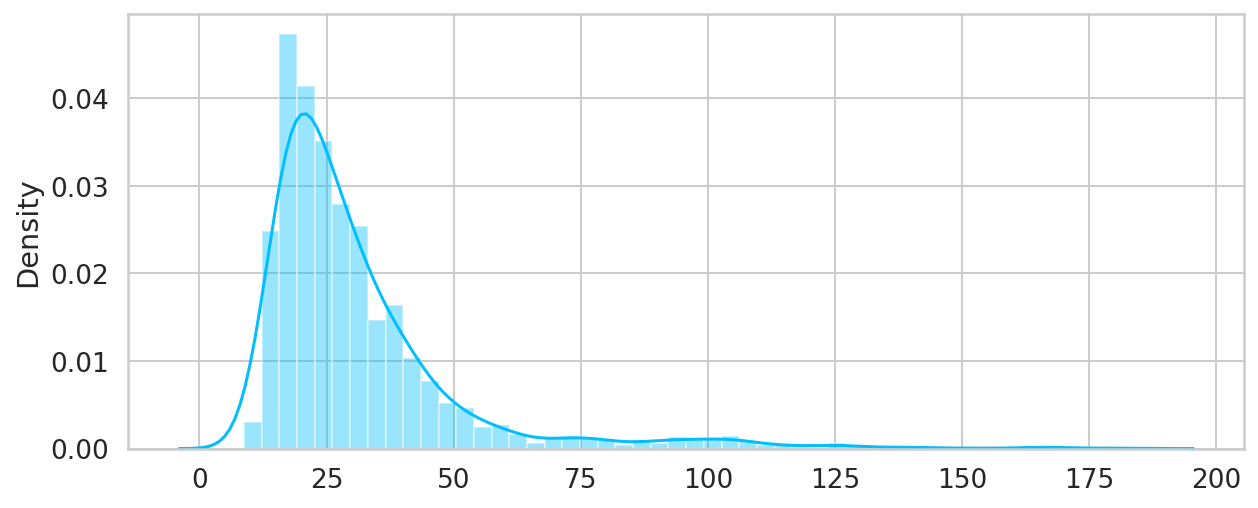

In [ ]:
sns.distplot(losses, bins=50, kde=True);

In [ ]:
threshold = np.mean(losses)
print(threshold)

31.164547


In [ ]:
def torch_classification_report(model, criterion, df_all, device, threshold, print_report = True, disable=False):
  all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all["target"].to_numpy()))
  all_sampler = SequentialSampler(all_data)
  all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
  total = len(all_dataloader)
  preds = []
  targets = []
  with tqdm(total = total, disable=disable) as ee:
    with torch.no_grad():
      for step, batch in enumerate(all_dataloader):
        model.eval()
        b_inputs, b_targets = tuple(t.to(device) for t in batch)
        out = model.forward(b_inputs)
        loss = criterion(out, b_inputs)

        targets.append(b_targets.item())

        if loss> threshold:
          preds.append(1)
        else:
          preds.append(0)
        ee.update()
    ee.close()
  f1 = f1_score(targets, preds)
  acc = accuracy_score(targets, preds)
  if print_report:
    print(classification_report(targets, preds))
  return acc, f1

def density_classification_report(model, criterion, df_all, device, losses, disable):
  f1s = []
  accs = []
  for loss in losses:
    acc, f1 = torch_classification_report(model, criterion, df_all, device, loss, print_report = False, disable=disable)
    f1s.append(f1)
    accs.append(acc)
  return accs, f1s

In [ ]:
anomaly_df = anomaly_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)
anomaly_df["target"] = 1
test_df["target"] = 0

all_df = pd.concat([anomaly_df,test_df]).reset_index(drop = True)

In [ ]:
acc, f1 = torch_classification_report(best_model, criterion, all_df, device, threshold, disable=False)


              precision    recall  f1-score   support

           0       0.98      0.72      0.83       145
           1       0.98      1.00      0.99      2081

    accuracy                           0.98      2226
   macro avg       0.98      0.86      0.91      2226
weighted avg       0.98      0.98      0.98      2226



In [ ]:
print(f"Accuracy: {acc}\nF1: {f1}")

Accuracy: 0.9811320754716981
F1: 0.99 


In [ ]:
arr = np.array(losses)
n_samples = 50
idx = np.random.randint(0,len(arr), size=n_samples)
sub_samples = arr[idx]
accs, f1s = density_classification_report(best_model, criterion, all_df, device, sub_samples,disable=True)

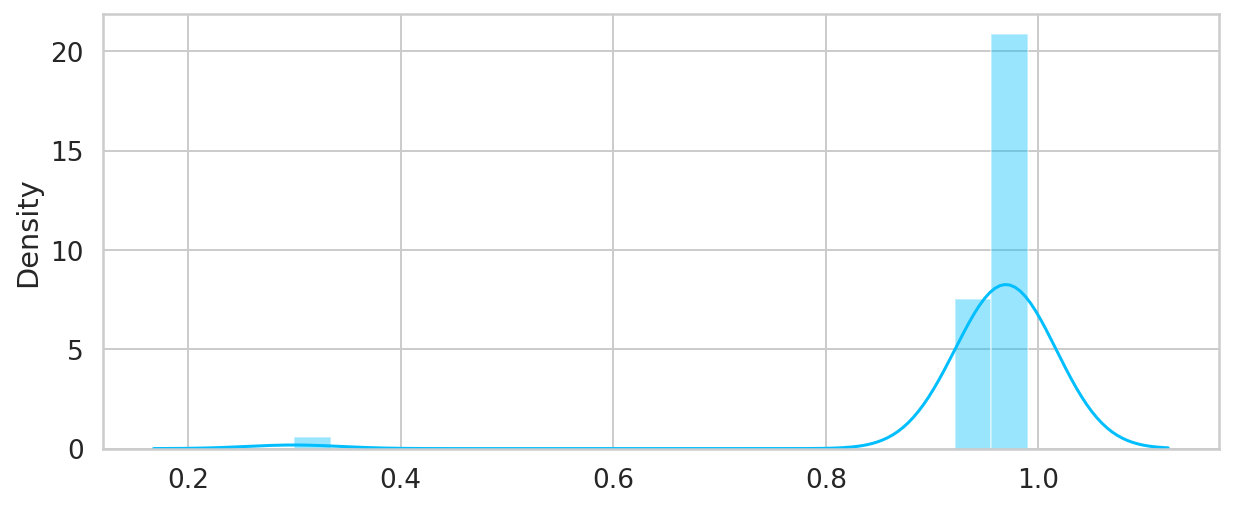

In [ ]:
sns.distplot(accs, bins=20, kde=True);

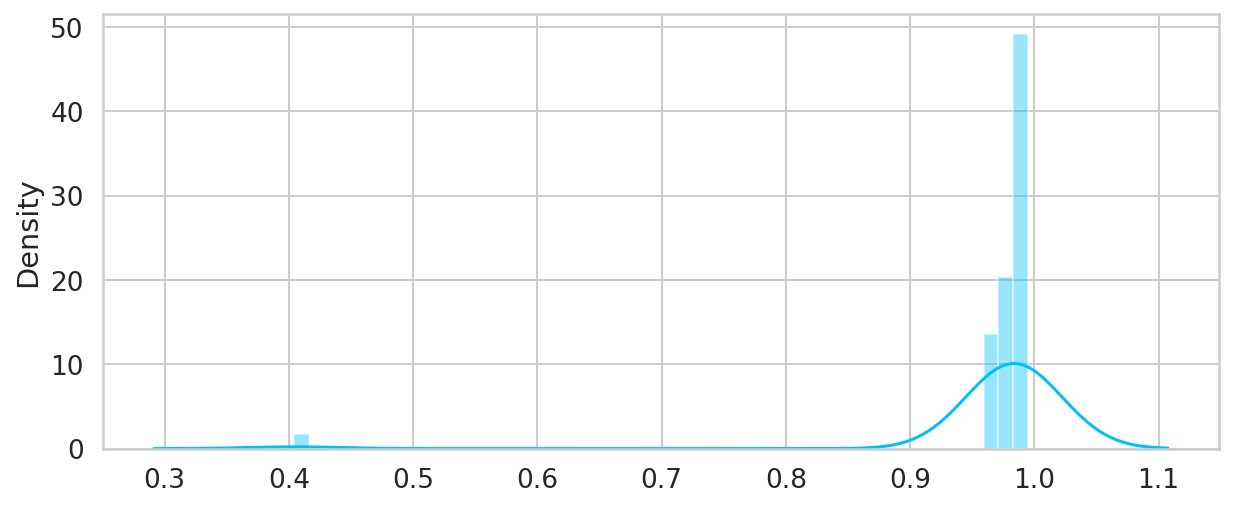

In [ ]:
sns.distplot(f1s, bins=50, kde=True);

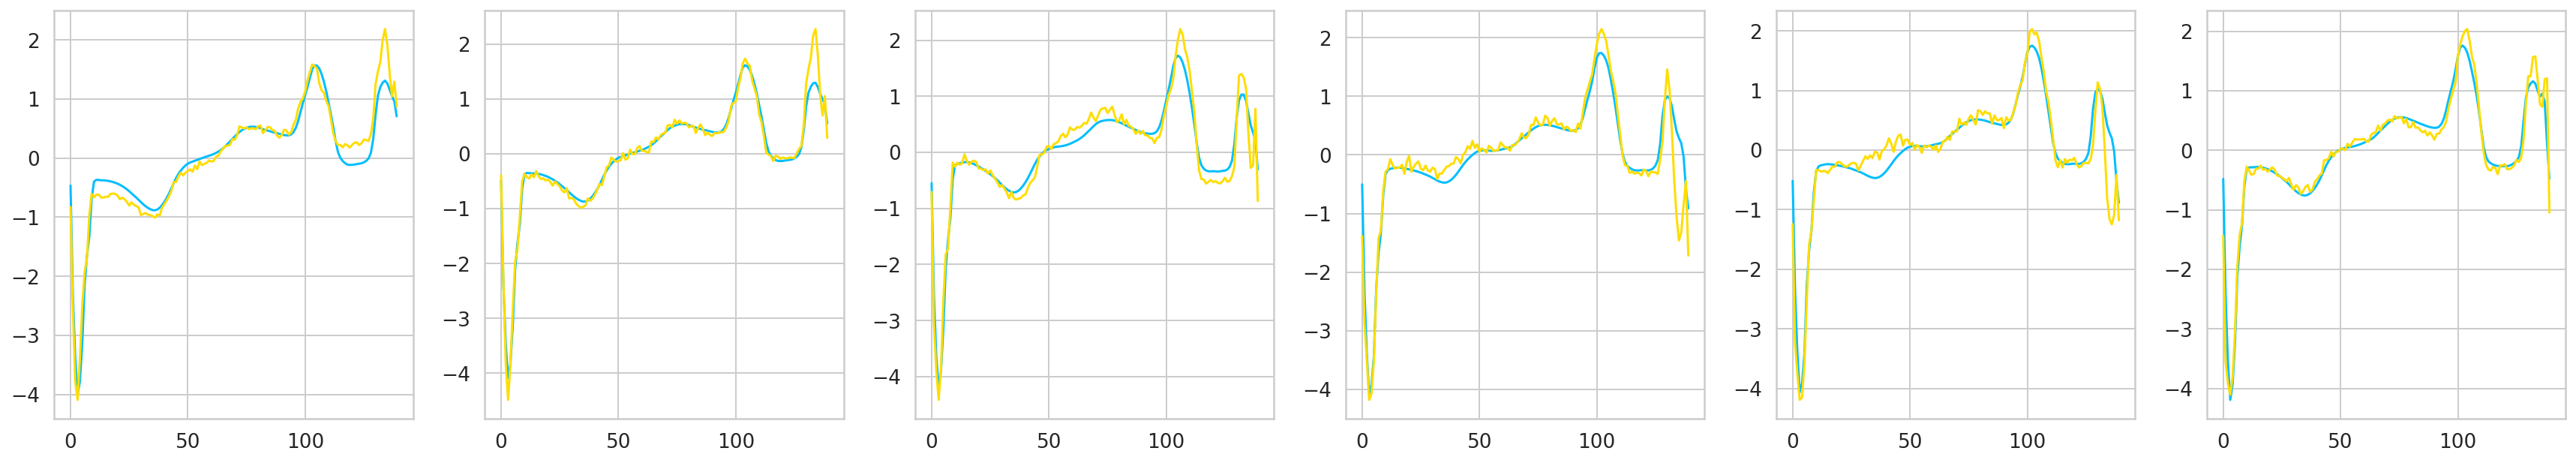

In [ ]:
fig, axs = plt.subplots(1,6,figsize=(30,5))
for i in range(6):
  axs[i].plot(reconstructions[i][0][0,:])
  axs[i].plot(reconstructions[i][1][0,:])